# Seminar 9. Monte-Carlo Markov Chains (MCMC)

Author: Kolesov Alexander

In [1]:
!pip install numpy torch statsmodels matplotlib seaborn

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 77.9 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 42.8 MB/s eta 0:00:00
DEPRECATION: pytorch-lightning 1.7.7 has a non-standard dependency specifier torch>=1.9.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: omegaconf 2.0.5 has a non-standard dependency specifier PyYAML>=5.1.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of omegaconf or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[

In [2]:
import numpy as np
import torch
import torch.distributions as dist

from statsmodels.tsa.stattools import acf

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

## 1. Motivation of sampling

### 1.1 Ensembling Motivation

First of all, it is necessary to start with motivations of MCMC. Let me return to the first motivation of the course that deals with the $\textbf{Ensembling}$.

We have :
- $p(t|x, \theta)$ prediction model  for labels t
- $p(\theta)$ prior for parameters of a model

As a result of the training, we have a model $ p(T_{tr}|X_{tr}, \theta)$ 

In accordance with Bayes' formula:

$$ p(\theta|X_{tr}, T_{tr}) = \frac{ p(T_{tr}|X_{tr}, \theta)p(\theta)}{\int_{\Theta}p(T_{tr}|X_{tr}, \theta)p(\theta)  d\theta} $$

Now,  we have new test element $X_{test}$ and we want to predict the coprresponding label:

$$ p(T_{test}|X_{test}, X_{tr}, T_{tr}, \theta) = \int_{\Theta} p(T_{test}, \theta|X_{test}, X_{tr}, T_{tr})d\theta = \int_{\Theta}p(T_{test}|X_{test},\theta)p(\theta|X_{tr}, T_{tr})d\theta$$ 

Finally:

$$ p(T_{test}|X_{test}, X_{tr}, T_{tr}, \theta) = \mathbb{E}_{p(\theta|X_{tr}, T_{tr})}p(T_{test}|X_{test},\theta)  $$

Thus, we are interested in Monte-Carlo simulation of the expectation, hence, we should have only samples from posterior to evaluate the aforementioned expression.

### 1.2 EM-algorithm

As for EM-algorothm:

$\textbf{E}$-step: approximate $p(z|x,\theta)$ to $p(z)$

$\textbf{M}$-step: maximize $\mathbb{E}_{p(z|x,\theta)} \log p(x,z)|\theta) \to  \max_{\theta}$

Conclusion? What do you think?

- we need in expectation of posterior

## 2. Monte-Carlo simulation

Let me make formalization a little bit: 
    
We are interested in the integral $\int p(z|x,\theta) log p(x,z|\theta)dz$, for simplicity, we denote this integral as: $\int p(x) f(x) dx$

Let me denote integral as $I = \int p(x)f(x)dx$ and the corresponding Monte-Carlo estimation as $J = \frac{1}{K}\sum_{k=1}^{K}f(x_{k})$ where $x_{k} \sim p(x)$

What do we know about $J$:

- J is a random variable
- What is the distribution of J ? 

Thus:

Since elements $x_{k}$ are independent and K is suffciently large, then in accordance with the $\textbf{Central limit theorem}$ 

$$ J \sim \mathcal{N}(I, \mathbb{D}J = \frac{1}{K^{2}}\sum_{k=1}^{K}D(f_{k}) = \frac{\mathbb{D}f}{K} )$$

Where $D(f) = \int p(x)(f(x) - I)^{2}dx$

Conclusions:


- More samples K, more accurate estimation
- Method is unbiased regrdless of Variational Inference (comparison)
- The variance does not depend on dimensionality 

How do have to get samples from distribution?

## 3. Inverse sampling

Useful materials:

- https://yandex.ru/video/preview/2366992462480508068
- https://sefidian.com/2021/10/07/inverse-cdf-transform-sampling/

Let $x$ is a random variable from a distribution $p(x)$. 

Introduce integral density function: $F(x) = \mathbb{P}(X < x)$. Then , one can substitute $X$ random variable to F  and estimate its probability:

$$ \mathbb{P} (F(X) < u) = \mathbb{P} (F^{-1}(F(x)) < F^{-1}(u)) = \mathbb{P} (X < F^{-1}(u) ) = F(F^{-1}(u)) = u   $$

Then:

$F(X) \sim U[0,1] \implies X = F^{-1}(u)$ 

In [1]:
# Example on lecture;

## 4. Rejection Sampling

Useful materials:
    
- https://gregorygundersen.com/blog/2019/09/01/sampling/

![title](https://upload.wikimedia.org/wikipedia/commons/a/a5/%D8%B1%D9%88%D8%B4_%D9%86%D9%85%D9%88%D9%86%D9%87%E2%80%8C%D8%A8%D8%B1%D8%AF%D8%A7%D8%B1%DB%8C_%D8%A8%D8%A7%D8%B2%D9%BE%D8%B3_%D8%B2%D9%86%D9%86%D8%AF%D9%87.png)

Let we have distribution $\hat{p}(x)$ and we want to sample from this distribution, however we don't have such ability

Let we have another distribution $q(x)$ and we can sample from this distribtuion 

and it is necessary to define constant $K > 1 : \forall x \implies kq(x) \geq \hat{p}(x)$ 

Algorithm:
    
- $x_{0} \sim q(x) $
- $u_{0} \sim U[0, kq(x_{0})]$
- if $u_{0} < \hat{p}(x)$ then accept

Calculate the probability that arbitrary point from $q(x)$ will be accepted:

$\mathbb{P(accept)}= \int \mathbb{P(accept|x_{0})}q(x)dx = \int \frac{\hat{p}(x_{0})}{Kq(x_{0})} q(x)dx  = \frac{1}{K}$

conclusion:

- Efficieny of the method
- Contrexample: Cauchy and Gaussian?

## 5. Importance sampling

materials:

- https://gregorygundersen.com/blog/2019/09/01/sampling/

conclsuion:
    
Which is a main disadvantage of Importance sampling?

## 6. MCMC

materials:
    
- https://gregorygundersen.com/blog/2019/11/02/metropolis-hastings/
- http://www.cmap.polytechnique.fr/~gobet/DemoPython/MetropolisHastings_GaussianSampling.html  (simple notebook)
- https://www.lakeheadu.ca/sites/default/files/uploads/77/Burke.pdf
- https://blog.djnavarro.net/posts/2023-04-12_metropolis-hastings/

![title](https://upload.wikimedia.org/wikipedia/commons/d/de/Flowchart-of-Metropolis-Hastings-M-H-algorithm-for-the-parameter-estimation-using-the.png)

### 6.1 Idea MCMC

Consider the following probabilistic model, that describes a sequence (Markov chain) $x_{1},...,x_{n}$:

 
     
$$p(x_{1},...,x_{n}) = p(x_{1})p(x_{2}|x_{1})...p(x_{n}|x_{n-1})$$
 

Deriving marginal distributions:

$p_{2}(x_{2}) = \int_{\mathcal{X}_{1}} p(x_{2}|x_{1})p(x_{1})dx_{1}$

$p_{3}(x_{3}) = \int_{\mathcal{X}_{1}}\int_{\mathcal{X}_{2}} p(x_{3}|x_{2})p(x_{2}|x_{1})p(x_{1})dx_{1}dx_{2}  $
 
$\textbf{Idea:}$

It is similar to transformation by operator with eigenvalue 1.
 
Probably, applying the operator $q(x'|x)$ to distribution $p(x)$, one can get $p(x')$ again.

### 6.2 Ergodicity

The distribution $p^{*}$ is referred to as \textbf{stationary} for homogeneous Markov chain:
\vspace{-2 mm}
$$p^{*}(x) = \int_{\mathcal{X}}q(x|x')p^{*}(x)dx'  $$
If Markov Chain is \textbf{ergodic}, then $p^{*}$  is the only one and exists.   
 
Then, we are interested in 2 questions:
 
-  $\textbf{Is homogeneous Markov chain ergodic?}$

$\forall x,x' \in \mathcal{X} \implies q(x'|x)>0 $  

- $ \textbf{Is desired distribution stationary ?  }$

$ p^{*}(x)q(x'|x) = p^{*}(x')q(x|x') $ Det. Balance 
\end{itemize}

### 6.3 Metropolis-Hastings Recap

Consider $\textbf{normalized}$ density function: $p(x) = \frac{\hat{p}(x)}{B}$


Introduce $\textbf{proposal}$ $r(\cdot|\cdot)$: $\forall x,x' \in \mathcal{X} \to r(x'|x)>0$

Example: $r(x'|x) = \mathcal{N}(x'|x,\sigma^{2}I)$


Set Metropolis-Hastings (MH) rule: 

$$A(x_{n},x') = \min(1, \frac{\hat{p}(x')r(x_{n}|x')}{\hat{p}(x_{n})r(x'|x_{n})})$$


$\textbf{Metropolis-Hastings algorithm:}$


- Sampling initial point $x_{0} \sim p_{0}(x)$

- Apply MH rule for $x_{n}$:

$x_{n+1} \sim r(x'|x_{n})A(x_{n},x') + \delta(x_{n}-x')(1 - \int r(y|x_{n})A(x_{n},y)dy)$

-  In practice: Set threshold for $A(\cdot,\cdot)$


## Metropolis-Hastings rejection

Let $\pi(\theta)$ be the distribution from which we want to sample. Suppose we are given unnormalized density $\hat{\pi}(\theta) = \frac{\pi(\theta)}{Z}$ where $Z$ is the normalizing constant. In MCMC methods we choose proposal density $q(\theta' \mid \theta)$, initial point $\theta_0$ and then we build a Markov chain like that:

For $t = 0, 1,\dots$: 
1. sample $\hat{\theta}_{t+1} \sim q(\theta' \mid \theta_t)$
2. Apply Metropolis-Hastings rejection:
$$\theta_{t+1} = \begin{cases}
\hat{\theta}_{t+1}, \text{ with probabilty } \rho(\hat{\theta}_{t+1} \mid \theta_t) \\
\theta_t, \text{ with probabilty } 1 - \rho(\hat{\theta}_{t+1} \mid \theta_t)
\end{cases}$$
where 
$$\rho(\theta' \mid \theta) = \min \left(1, \frac{\hat{\pi}(\theta')q(\theta \mid \theta')}{\hat{\pi}(\theta)q(\theta' \mid \theta)} \right)$$

Below you can see Python class for MCMC method. You need to implement `acceptance_prob` method which computes $\rho(\theta' \mid \theta)$. Everything else is already implemented for you.

In [15]:
class Distribution:
    """Abstract class for unnormalized distribution"""
    
    def log_density(self, x):
        """
            Computes vectorized log of unnormalized log density
            
            x (torch tensor of shape BxD): B points at which we compute log density
            returns (torch tensor of shape B): \log \hat{\pi}(x) 
        """
        raise NotImplementedError
        
    def grad_log_density(self, x):
        """
            Computes vectorized gradient \nabla_x \log \pi(x)
            
            x (torch tensor of shape BxD): point at which we compute \nabla \log \pi
            returns (torch.tensor of shape BxD): gradients of log density
        """
        x = x.clone().requires_grad_()
        logp = self.log_density(x)
        logp.sum().backward()
        return x.grad

class Proposal:
    """Abstract class for proposal"""
    
    def sample(self, x):
        """
            Computes vectorized sample from proposal q(x' | x)
            
            x (torch tensor of shape BxD): current point from which we propose
            returns: (torch tensor of shape BxD) new points
        """
        raise NotImplementedError

    def log_density(self, x, x_prime):
        """
            Computes vectorized log of unnormalized log density
            
            x (torch tensor of shape BxD): B points at which we compute log density
            returns (torch tensor of shape B): \log q(x' | x) 
        """
        raise NotImplementedError
        
class MCMC:
    def __init__(self, distribution, proposal):
        """
            Constructs MCMC sampler
        
            distribution (Distribution): distribution from which we sample
            proposal (Proposal): MCMC proposal
        """
        self.distribution = distribution
        self.proposal = proposal
    
    def _step(self, x):
        x_prime = self.proposal.sample(x)
        acceptance_prob = self.acceptance_prob(x_prime, x)
        
        mask = torch.rand(x.shape[0]) < acceptance_prob
        x[mask] = x_prime[mask]
        self._rejected += (~mask).type(torch.float32)
        return x

    def simulate(self, initial_point, n_steps, n_parallel=10):
        """
            Run `n_parallel ` simulations for `n_steps` starting from `initial_point`
            
            initial_point (torch tensor of shape D): starting point for all chains
            n_steps (int): number of samples in Markov chain
            n_parallel (int): number of parallel chains
            returns: dict(
                points (torch tensor of shape n_parallel x n_steps x D): samples
                n_rejected (numpy array of shape n_parallel): number of rejections for each chain
                rejection_rate (float): mean rejection rate over all chains
                means (torch tensor of shape n_parallel x n_steps x D): means[c, s] = mean(points[c, :s])
                variances (torch tensor of shape n_parallel x n_steps x D): variances[c, s, d] = variance(points[c, :s, d])
            )
        """
        xs = []
        x = initial_point.repeat(n_parallel, 1)
        self._rejected = torch.zeros(n_parallel)
        
        dim = initial_point.shape[0]
        sums = np.zeros([n_parallel, dim])
        squares_sum = np.zeros([n_parallel, dim])
        
        means = []
        variances = []        
        
        for i in range(n_steps):
            x = self._step(x)
            xs.append(x.numpy().copy())
            
            sums += xs[-1]
            squares_sum += xs[-1]**2
            
            mean, squares_mean = sums / (i + 1), squares_sum / (i + 1)
            means.append(mean.copy())
            variances.append(squares_mean - mean**2)
        
        xs = np.stack(xs, axis=1)        
        means = np.stack(means, axis=1)
        variances = np.stack(variances, axis=1)
        
        return dict(
            points=xs,
            n_rejected=self._rejected.numpy(),
            rejection_rate=(self._rejected / n_steps).mean().item(),
            means=means,
            variances=variances
        )
        
    def acceptance_prob(self, x_prime, x):
        """
            In this function you need to compute 
            probability of acceptance \rho(x' | x)

            x_prime (numpy array): new point
            x (numpy array): current point
            returns: acceptance probability \rho(x', x)
        """
    
        # TODO
        pi_new = self.distribution.log_density(x_prime)
        pi_old = self.distribution.log_density(x)
        q_new = self.proposal.log_density(x_prime, x)
        q_old = self.proposal.log_density(x, x_prime)
        ratio = torch.exp(pi_new - pi_old + q_new - q_old)
        return ratio.clamp(0., 1.)
    
def simulate(distribution, proposal, initial_point, n_samples, n_parallel=10):
    mcmc = MCMC(distribution, proposal)
    return mcmc.simulate(initial_point, n_samples, n_parallel)

# Plotting utils

In [16]:
def plot_points(xs, ax, i=0, j=1, color=True):
    ax.set_title('points')
    ax.set_xlabel(f'coordinate {i}')
    ax.set_ylabel(f'coordinate {j}')
    
    n_parallel, n_samples, _ = xs.shape
    c = np.arange(n_samples) if color else None
    for k in range(n_parallel):
        ax.scatter(xs[k, :, i], xs[k, :, j], s=5, c=c)
    return ax

def plot_log_density(xs, ax, distribution):
    ax.set_title('log_density')
    ax.set_xlabel('iteration')
    ax.set_ylabel('log density')
    
    n_parallel, n_samples, _ = xs.shape
    for k in range(n_parallel):
        density = distribution.log_density(torch.tensor(xs[k]))
        ax.plot(density.numpy(), label=f'run {k + 1}')
    ax.legend(loc='best')
    return ax

def find_first(X):
    for i in range(X.shape[0]):
        if X[i]:
            return i
    return -1
  
def integrated_autocorr(x, acf_cutoff=0.0):
    if x.ndim == 1:
        x = x.reshape(-1, 1)
    n = len(x)

    tau = np.zeros(x.shape[1])
    for j in range(x.shape[1]):
        f = acf(x[:,j], nlags=n, unbiased=False, fft=True)
        window = find_first((f <= acf_cutoff).astype(np.uint8))
        tau[j] = 1 + 2*f[1:window].sum()

    return tau

def compute_ess(x, acf_cutoff=0.0):
    tau = integrated_autocorr(x, acf_cutoff=acf_cutoff)
    return x.shape[0] / tau
  
def plot_autocorr(xs, axes, step=100, mean=False, label=None):
    n_parallel, _, dim = xs.shape
    
    for i in range(dim):
        axes[i].set_title(f'autocorrelation (step={step}, coordinate {i})')
        axes[i].set_xlabel('lag')
        axes[i].set_ylabel('autocorrelation')
        
        acfs = [acf(xs[k, ::step, i]) for k in range(n_parallel)]
        ess = np.stack([compute_ess(xs[k]) for k in range(n_parallel)], axis=0)
        
        if mean:
            axes[i].plot(np.mean(acfs, axis=0), marker='o', label=(label or '') + f" ESS = {ess.mean(axis=0)[i]:.2f}")
        else:
            for k, acf_ in enumerate(acfs):
                axes[i].plot(acf_, marker='o', label=f'run {k} ESS = {ess[k][i]:.2f}')
            
        axes[i].legend(loc='best')
    return axes
        
def cummean(arr, axis=0):
    if axis < 0:
        axis = axis + len(arr.shape)
    
    arange = np.arange(1, arr.shape[axis] + 1)
    arange = arange.reshape((1,) * axis + (-1,) + (1,) * (len(arr.shape) - axis - 1))
    return arr.cumsum(axis=axis) / arange
    
def plot_statistics(xs, axes, skip=0, step=1):
    xs = xs[:, skip::step]
    n_parallel, _, dim = xs.shape
    
    means = cummean(xs, axis=1)
    variances = cummean(xs**2, axis=1) - means**2
    
    for i in range(n_parallel):
        for j in range(dim):
            ax = axes[j]
            ax.set_title(f'coordinate {j} running mean and std')
            ax.set_xlabel('iteration')
            ax.set_ylabel(f'coordinate {j}')
            
            x = np.arange(means.shape[1])
            y = means[i, :, j]
            e = np.sqrt(variances[i, :, j])
            
            r = ax.plot(y, label=f'chain {i} mean')
            ax.plot(e, linestyle='--', c=r[0].get_color(), label=f'chain {i} std')
            ax.legend(loc='best')
        
    return axes
  
def plot_traceplot(xs, axes):
    n_parallel, _, dim = xs.shape
    
    for i in range(n_parallel):
        for j in range(dim):
            ax = axes[j]
            ax.set_title(f'coordinate {j} traceplot')
            ax.set_xlabel('iteration')
            ax.set_ylabel(f'coordinate {j}')
           
            ax.plot(xs[i, :, j], label=f'chain {i}')
            ax.legend(loc='best')
        
    return axes

def plot_distribution(distribution, bounds, ax, num=50, n_levels=None, filled=False, exp=False):
    x_min, x_max = bounds[0]
    y_min, y_max = bounds[1]
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    x, y = np.meshgrid(np.linspace(x_min, x_max, num=num), np.linspace(y_min, y_max, num=num))
    s = x.shape
    xy = np.stack([x.reshape(-1), y.reshape(-1)], axis=1)
    z = distribution.log_density(torch.tensor(xy, dtype=torch.float32)).numpy().reshape(s)
    if exp:
      z = np.exp(z)
    
    plot = ax.contourf if filled else ax.contour
    r = plot(x, y, z, n_levels)
    return ax, r

def plot_distribution_grad(distribution, bounds, ax, num=50):
    x_min, x_max = bounds[0]
    y_min, y_max = bounds[1]
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    x, y = np.meshgrid(np.linspace(x_min, x_max, num=num), np.linspace(y_min, y_max, num=num))
   
    s = x.shape
    xy = np.stack([x.reshape(-1), y.reshape(-1)], axis=1)
    z = distribution.grad_log_density(torch.tensor(xy, dtype=torch.float32)).numpy()
    u, v = z[..., 0], z[..., 1]
    c = np.sqrt(u**2 + v**2)
    
    ax.quiver(x, y, u, v, c, angles='xy')
    return ax

# Distributions

In this seminar we consider four distributions on which we test different properties of MCMC methods.
1. Typical normal isotropic distribution: $$\pi(x) = \mathcal{N}(x \mid \mu, \sigma^2 I)$$
2. Scaled normal distribution: $$\pi(x) = \mathcal{N}(x \mid \mu, D)$$
3. Mixture of normals: $$\pi(x) = \frac{1}{N}\sum_{k=1}^N \mathcal{N}(x \mid \mu_k, D_k)$$
4. Langevin mixture: $$
\begin{align*}
    & \pi(\theta) = p(\theta \mid X) \propto p(X \mid \theta)p(\theta) \\
    & p(X \mid \theta) = \prod_{k=1}^N \left[ \frac{1}{2}\mathcal{N}(x_k \mid \theta_1, \sigma_x^2) + \frac{1}{2}\mathcal{N}(x_k \mid \theta_1 + \theta_2, \sigma_x^2) \right] \\
    & p(\theta) = \mathcal{N}(\theta_1 \mid 0, \sigma_1^2)\mathcal{N}(\theta_2 \mid 0, \sigma_2^2)
\end{align*}
$$ This is example is from [the paper](https://www.ics.uci.edu/~welling/publications/papers/stoclangevin_v6.pdf) on Langevin Dynamics.

**Hint:** mind the shape, `log_density` assumes that input is a batch of points (for running several parallel MCMC chains).

In [17]:
class Normal(Distribution):
    """Represents normal distribution N(mean, std)"""
    
    def __init__(self, loc, scale):
        """
            loc (torch tensor of shape D): mean
            scale (torch tensor of shape D) std
        """
        self.dist = dist.Normal(loc=loc, scale=scale)

    def log_density(self, x):
        return self.dist.log_prob(x).sum(dim=-1)
    

class MixtureOfNormals(Distribution):
    """Represents mixture of normals: \pi(x) = \sum_k \pi_k N(x | mean_k, std_k)"""
    def __init__(self, locs, scales, pi):
        """
            locs (torch tensor of shape NxD): locs[k] = mean_k
            scales (torch tensor of shape NxD): scales[k] = std_k
            pi (torch.tensor of shape N): pi[k] = pi_k
        """
        self.dists = [
            dist.Normal(loc=loc, scale=scale)
            for loc, scale in zip(locs, scales)
        ]
        self.pi = pi
        
    def log_density(self, x):
        log_densities = torch.stack([
            d.log_prob(x).sum(dim=-1)
            for d in self.dists
        ], dim=0)
        return torch.logsumexp(torch.log(self.pi).view(-1, 1) + log_densities, dim=0)

    
class LangevinMixture(Distribution):
    """
        This distribution is defined as posterior on theta_1, theta_2 given
        prior: theta_1 ~ N(0, \sigma_1^2), theta_2 ~ N(0, \sigma_2^2)
        likelihood: x_i ~ 0.5 * N(theta_1, \sigma_x^2) + 0.5 * N(theta_1 + theta_2, \sigma_x^2)
        
        More detailed information can be found at 
        https://www.ics.uci.edu/~welling/publications/papers/stoclangevin_v6.pdf
    """
    
    def __init__(self, theta1=0., theta2=1., 
                       s1=np.sqrt(10.), s2=1., sx=np.sqrt(2.), N=100):
        mu = torch.tensor([theta1, theta1 + theta2])
        pi = np.random.binomial(n=1, p=0.5, size=N).astype(np.int64)

        d = dist.Normal(loc=mu, scale=sx)
        self.X = d.sample((N,))[np.arange(N), pi]
    
        self.d1 = dist.Normal(loc=0., scale=s1)
        self.d2 = dist.Normal(loc=0., scale=s2)
        self.dx = dist.Normal(loc=0., scale=sx)
    
    def log_density(self, theta):
        theta1, theta2 = theta[..., 0], theta[..., 1]
        log_prior = self.d1.log_prob(theta1) + self.d2.log_prob(theta2)
        
        mu = torch.stack([theta1, theta1 + theta2], dim=-1)
        
        log_likelihood = self.dx.log_prob(self.X[None, :, None] - mu[:, None])
        log_likelihood = torch.logsumexp(log_likelihood, dim=-1)
        return log_prior + log_likelihood.sum(dim=-1)

# Proposals

We will study one proposal distributions.

1. Random walk:
$$q(\theta' \mid \theta) = \mathcal{N}(\theta' \mid \theta, \sigma^2)$$

In [18]:
class RandomWalk(Proposal):
    """Proposal of the form q(x' | x) = N(x' | x, \sigma^2)"""
    
    def __init__(self, sigma):
        self.sigma = sigma
        self.d = dist.Normal(loc=0., scale=sigma)
        
    def sample(self, x):
        return x + self.d.sample(sample_shape=x.shape)
    
    def log_density(self, x, x_prime):
        return self.d.log_prob(x_prime - x).sum()
    
    def __str__(self):
        return f"Random walk sigma={self.sigma}"

# Experiments

First of all, let's plot all the probability distributions to better understand what we deal with. Plots are in log-domain, pass `exp=True` to `plot_distribution` to have the real density

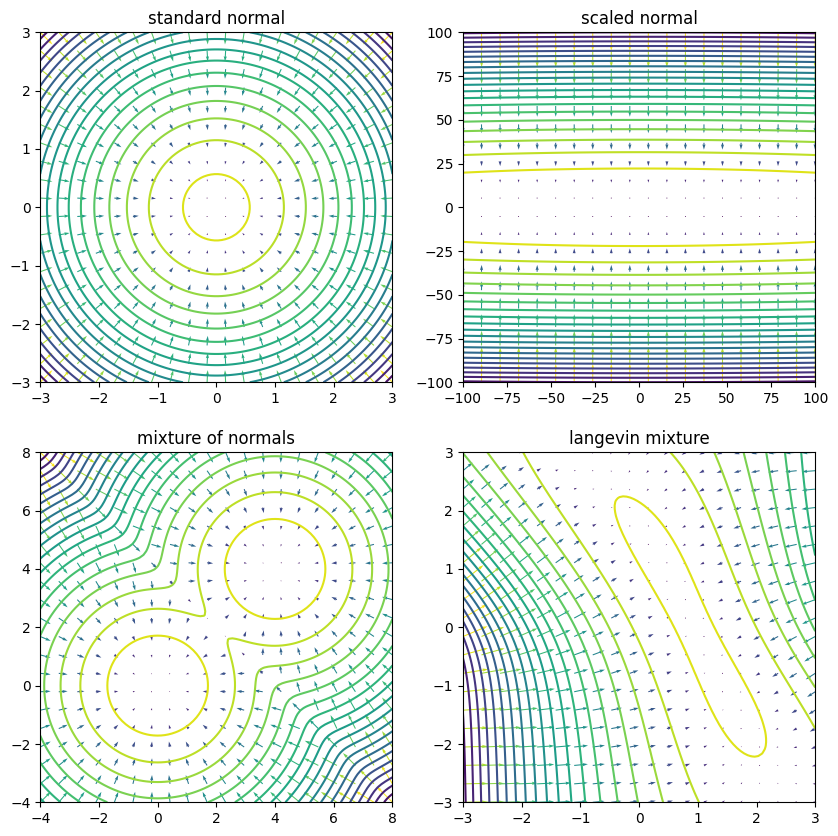

In [7]:
standard_normal = Normal(loc=0., scale=1.)
scaled_normal = Normal(loc=0., scale=torch.tensor([10., 1.]))
mixture = MixtureOfNormals(
    locs=[torch.tensor([0., 0.]), torch.tensor([4., 4.])], 
    scales=[1., 1.],
    pi=torch.tensor([0.5, 0.5])
)

langevin = LangevinMixture()

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
plot_distribution(standard_normal, bounds=((-3, 3), (-3, 3)), ax=axes[0][0], num=100, n_levels=20)
plot_distribution_grad(standard_normal, bounds=((-3, 3), (-3, 3)), ax=axes[0][0], num=20)
axes[0][0].set_title('standard normal')

plot_distribution(scaled_normal, bounds=((-100, 100), (-100, 100)), ax=axes[0][1], num=100, n_levels=20)
plot_distribution_grad(scaled_normal, bounds=((-100, 100), (-100, 100)), ax=axes[0][1], num=20)
axes[0][1].set_title('scaled normal')

plot_distribution(mixture, bounds=((-4, 8), (-4, 8)), ax=axes[1][0], num=100, n_levels=20)
plot_distribution_grad(mixture, bounds=((-4, 8), (-4, 8)), ax=axes[1][0], num=20)
axes[1][0].set_title('mixture of normals')

plot_distribution(langevin, bounds=((-3, 3), (-3, 3)), ax=axes[1][1], num=100, n_levels=20)
plot_distribution_grad(langevin, bounds=((-3, 3), (-3, 3)), ax=axes[1][1], num=20)
axes[1][1].set_title('langevin mixture');

## Sampler tuning

The most important issue when working with MCMC is the hyperparameter tuning. One useful quantity to track is rejection rate. Plot samples and rejection rate for different proposals and hyperparameters. What can you say about dependence of rejection rate and quality of sampling?

In [8]:
def tuning_experiment(distribution, proposal, hyperparameters, options, color=True):
    fig, axes = plt.subplots(ncols=len(hyperparameters), figsize=(20, 20))

    for i, hp in enumerate(hyperparameters):
        result = simulate(distribution, proposal(**hp), **options)
        ax = axes[i]
        plot_points(result['points'], ax, color=color)
        
        ax.set_aspect('equal')
        hp_string = ', '.join(f'{k}={v}' for k, v in hp.items())
        ax.set_title(f'{hp_string}, rejection rate = {result["rejection_rate"]:.2f}')
        ax.set_xlim(-4., 4.)
        ax.set_ylim(-4., 4.)

**Note:** by default `plot_points` makes the color of point brighter if it is the point from later iteration. You can see different chains by setting `color=False`.

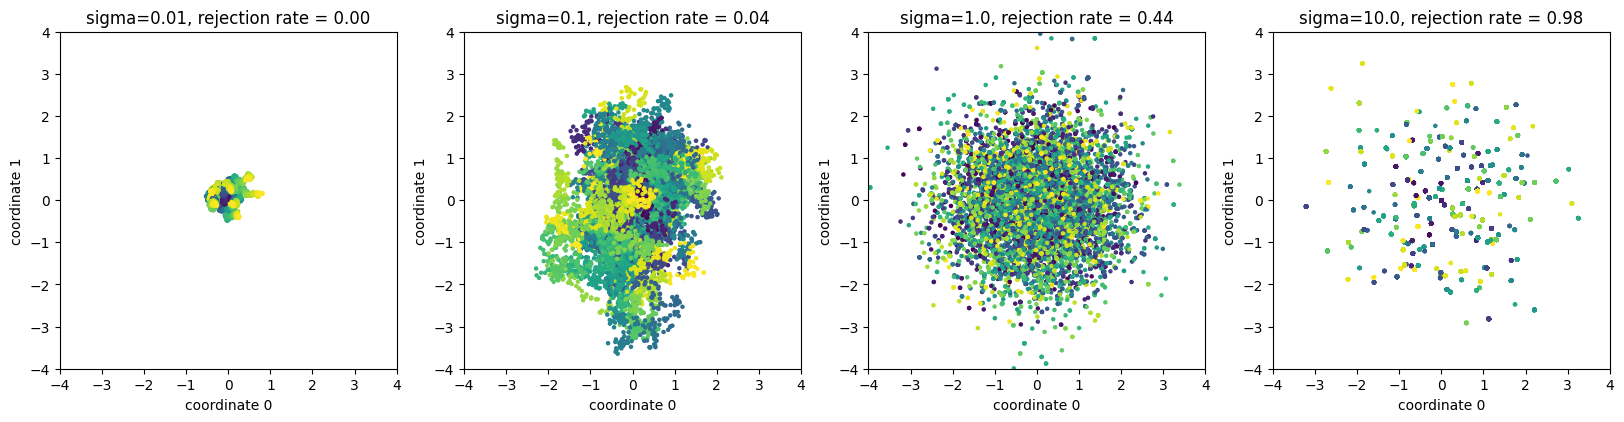

In [19]:
# choose some sigmas and run simulations
sigmas = [0.01, 0.1, 1.0, 10.]

tuning_experiment(
    standard_normal,
    proposal=RandomWalk,
    hyperparameters=[dict(sigma=s) for s in sigmas],
    options = dict(
        initial_point=torch.tensor([0., 0.]),
        n_samples=1000,
        n_parallel=10
    )
)

## Scale of distribution

Use the same proposals but for the scaled normal distribution. How hyperparameters and number of samples necessary to cover the distribution changes.

In [20]:
def run_many_proposals(distribution, proposals, options, bounds=[(-40, 40), (-4, 4)]):
    fig, axes = plt.subplots(nrows=len(proposals), figsize=(20, 10))

    for i, proposal in enumerate(proposals):
        result = simulate(distribution, proposal, **options)
        ax = axes[i]
        plot_points(result['points'], ax)
        ax.set_title(f'{proposal}, rejection rate = {result["rejection_rate"]:.2f}')
        ax.set_xlim(*bounds[0])
        ax.set_ylim(*bounds[1])
        ax.set_aspect('equal')

    fig.tight_layout()

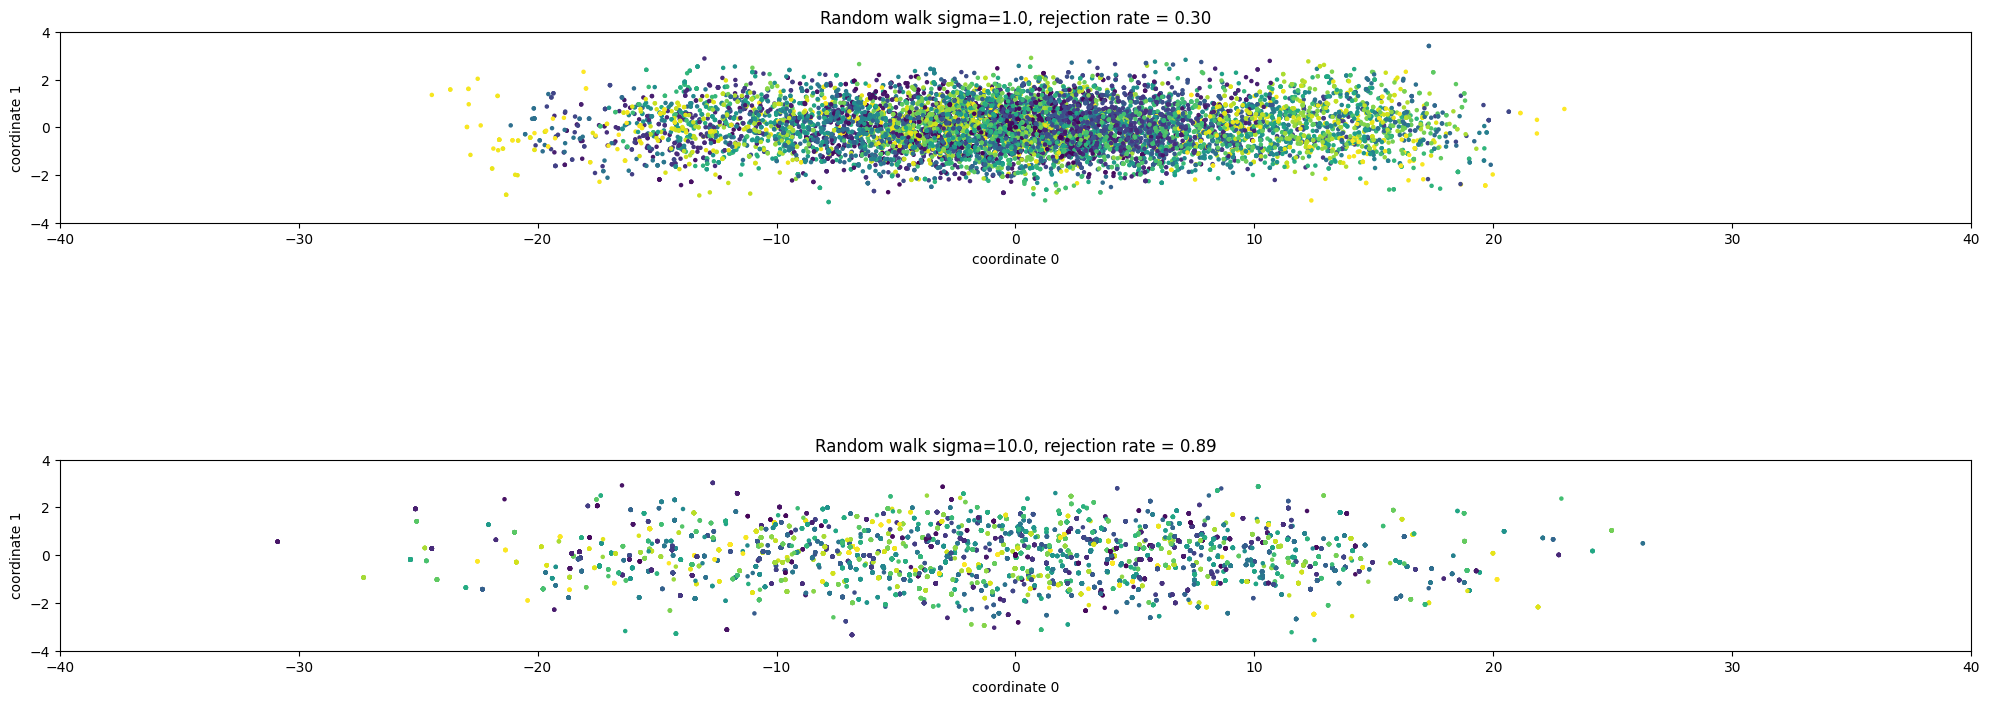

In [21]:
# Try out different proposals
proposals = [
        RandomWalk(1.0),
        RandomWalk(10.0)
]

run_many_proposals(
    scaled_normal,
    proposals=proposals,
    options = dict(
        initial_point=torch.tensor([0., 0.]),
        n_samples=1000,
        n_parallel=10
    )
)

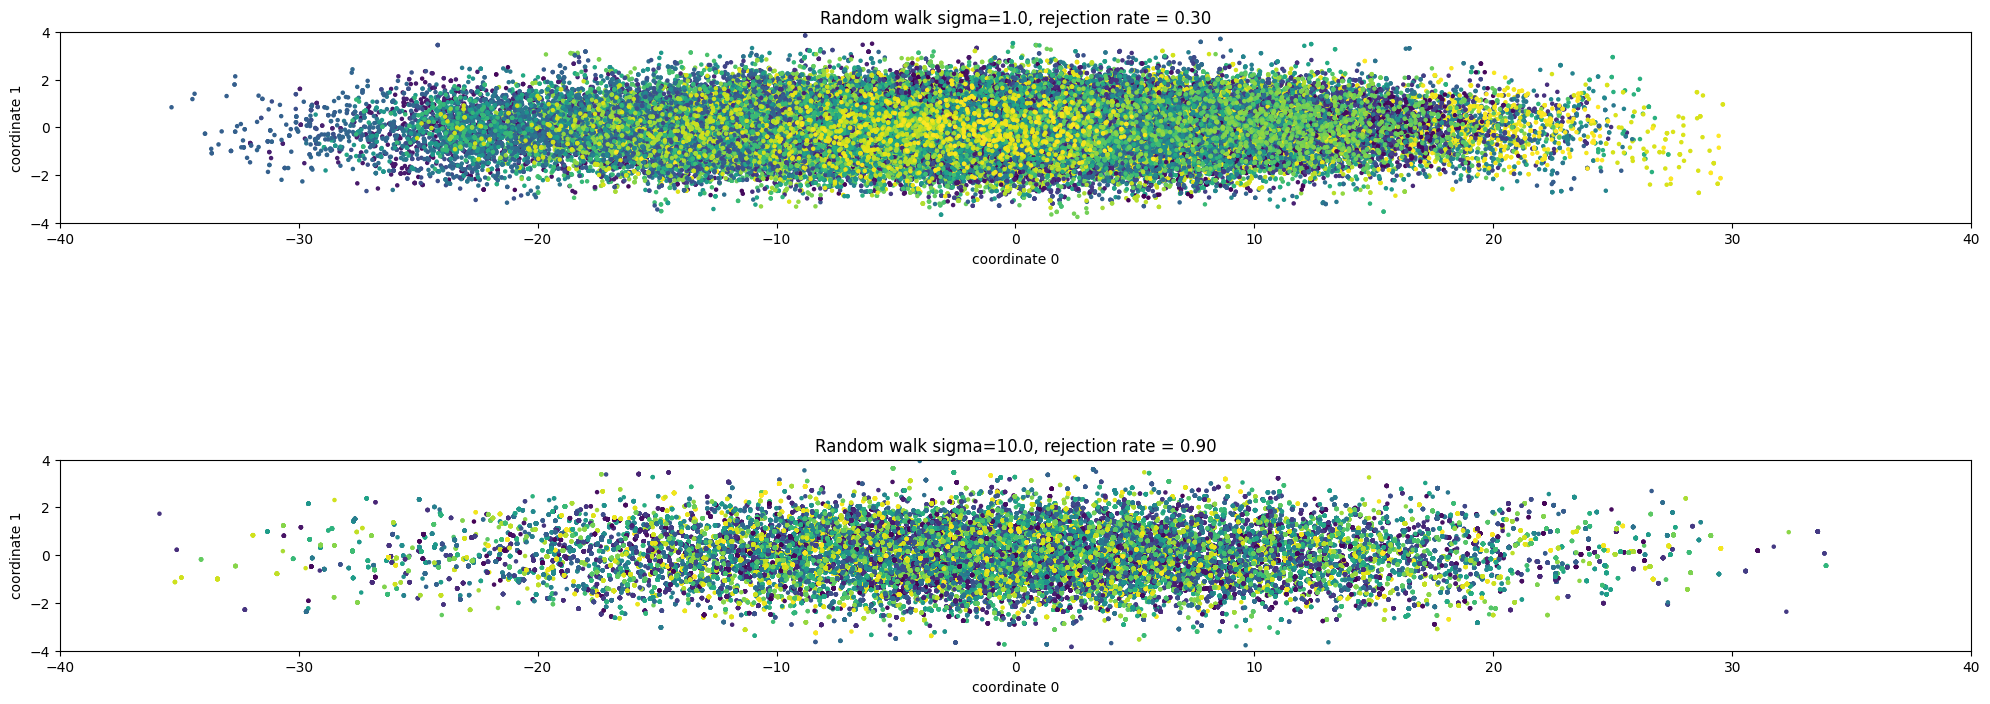

In [22]:
# Now with 10x more samples

run_many_proposals(
    scaled_normal,
    proposals=proposals,
    options = dict(
        initial_point=torch.tensor([0., 0.]),
        n_samples=10000,
        n_parallel=10
    )
)

## Multi-modality

Research how MCMC deals with multimodal distributions. For Gaussian mixture start in one mode and try to reach the other. Watch how this changes with increasing distance between the modes.

### Gaussian mixture

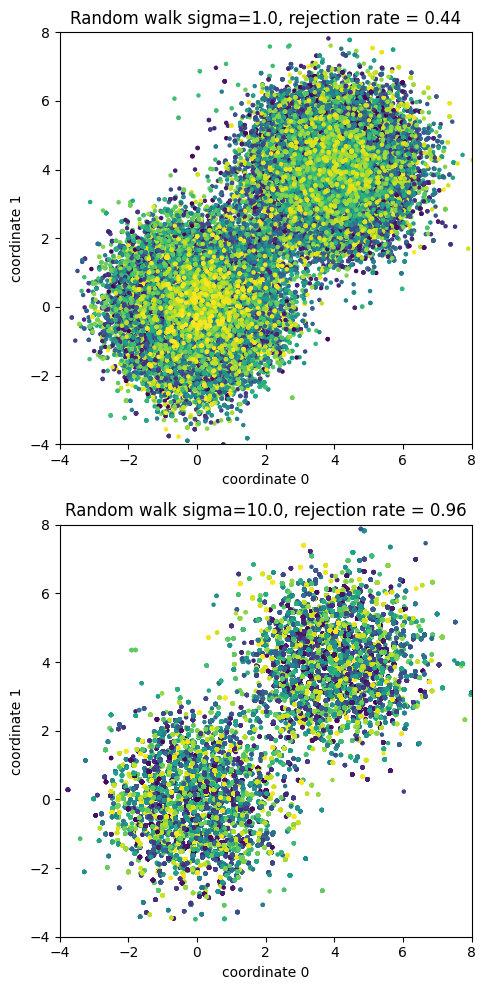

In [25]:
run_many_proposals(
    mixture,
    proposals=[
        RandomWalk(1.0), 
        RandomWalk(10.0)
    ],
    options = dict(
        initial_point=torch.tensor([0., 0.]),
        n_samples=10000,
        n_parallel=10
    ),
    bounds=[(-4, 8), (-4, 8)]
)

<AxesSubplot:>

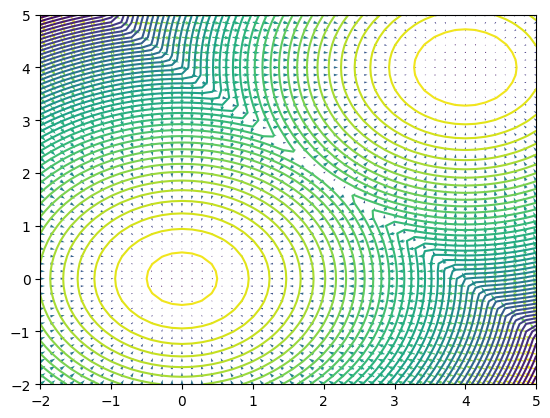

In [26]:
dst = MixtureOfNormals(
    locs=[torch.tensor([0., 0.]), torch.tensor([4., 4.])], 
    scales=[0.4, 0.4],
    pi=torch.tensor([0.3, 0.7])
)
bnds = [(-2, 5), (-2, 5)]
plot_distribution(dst, bnds, plt.gca(), n_levels=50)
plot_distribution_grad(dst, bnds, plt.gca())

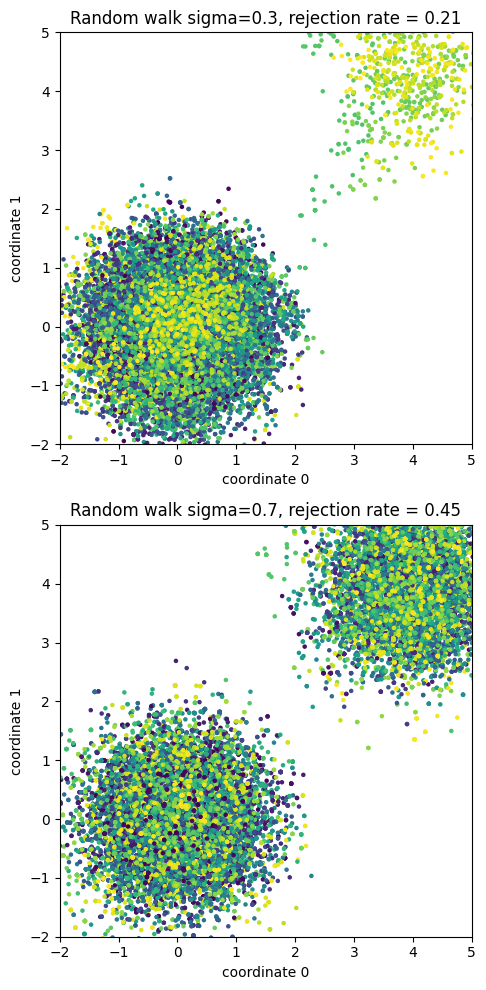

In [27]:
# Try changing the scales of mixture parts and observe how samples change

dst = MixtureOfNormals(
        locs=[torch.tensor([0., 0.]), torch.tensor([4., 4.])], 
        scales=[0.7, 0.7],
        pi=torch.tensor([0.3, 0.7])
    )

run_many_proposals(
    dst,
    proposals=[
        RandomWalk(0.3),
        RandomWalk(0.7)
         
    ],
    options = dict(
        initial_point=torch.tensor([0., 0.]),
        n_samples=3000,
        n_parallel=10
    ),
    bounds=[(-2, 5), (-2, 5)]
)

### Langevin mixture

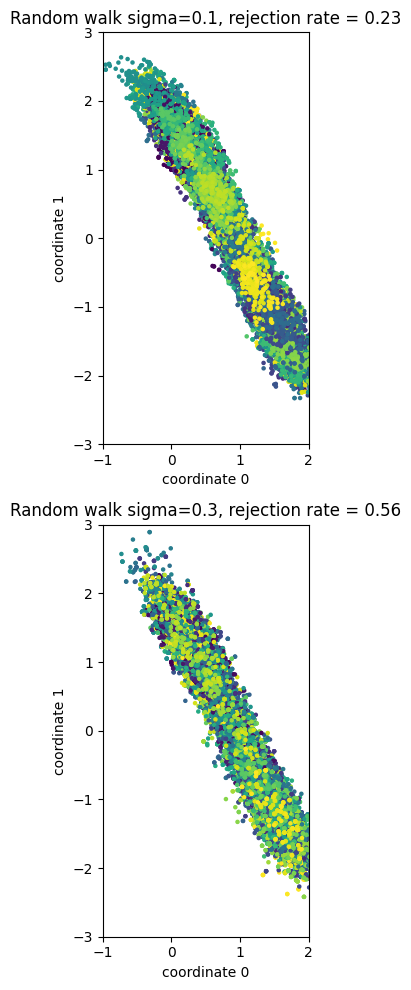

In [28]:
run_many_proposals(
    langevin,
    proposals=[
        RandomWalk(0.1),
        RandomWalk(0.3)
         
    ],
    options = dict(
        initial_point=torch.tensor([0., 1.]),
        n_samples=3000,
        n_parallel=10
    ),
    bounds=[(-1, 2), (-3, 3)]
)

## Detection of convergence

In previous experiments we usually started from the mode of the distribution. This is not the case in many situations and in fact we might not even start from a typical point from the distribution. We need means to detect MCMC convergence. The easiest way to detect it by watching statistics of $N$ last samples and/or same statistics of different chains.

In [29]:
def convergence_detection_experiment(distribution, proposals, options, bounds=[(-2, 2), (-3, 3)]):
    D = options['initial_point'].shape[0]
    fig = plt.figure(constrained_layout=True, figsize=(20, 10))
    gs = fig.add_gridspec(2 * len(proposals), 1 + D)

    for i, proposal in enumerate(proposals):
        result = simulate(distribution, proposal, **options)
        ax = [fig.add_subplot(gs[2*i:2*i+2, 0])] + [fig.add_subplot(gs[2*i, 1+k]) for k in range(D)] + [fig.add_subplot(gs[2*i+1, 1+k]) for k in range(D)]
        plot_points(result['points'], ax[0])
        plot_statistics(result['points'], ax[1:1 + D])
        plot_traceplot(result['points'], ax[1 + D: 1 + 2 * D])

        ax[0].set_title(f'{proposal}, rejection rate = {result["rejection_rate"]:.2f}')
        ax[0].set_xlim(*bounds[0])
        ax[0].set_ylim(*bounds[1])
        ax[0].set_aspect('equal')

<ipython-input-16-28abf2d8659c>:91: RuntimeWarning: invalid value encountered in sqrt
  e = np.sqrt(variances[i, :, j])
<ipython-input-16-28abf2d8659c>:91: RuntimeWarning: invalid value encountered in sqrt
  e = np.sqrt(variances[i, :, j])
<ipython-input-16-28abf2d8659c>:91: RuntimeWarning: invalid value encountered in sqrt
  e = np.sqrt(variances[i, :, j])
<ipython-input-16-28abf2d8659c>:91: RuntimeWarning: invalid value encountered in sqrt
  e = np.sqrt(variances[i, :, j])
<ipython-input-16-28abf2d8659c>:91: RuntimeWarning: invalid value encountered in sqrt
  e = np.sqrt(variances[i, :, j])
<ipython-input-16-28abf2d8659c>:91: RuntimeWarning: invalid value encountered in sqrt
  e = np.sqrt(variances[i, :, j])


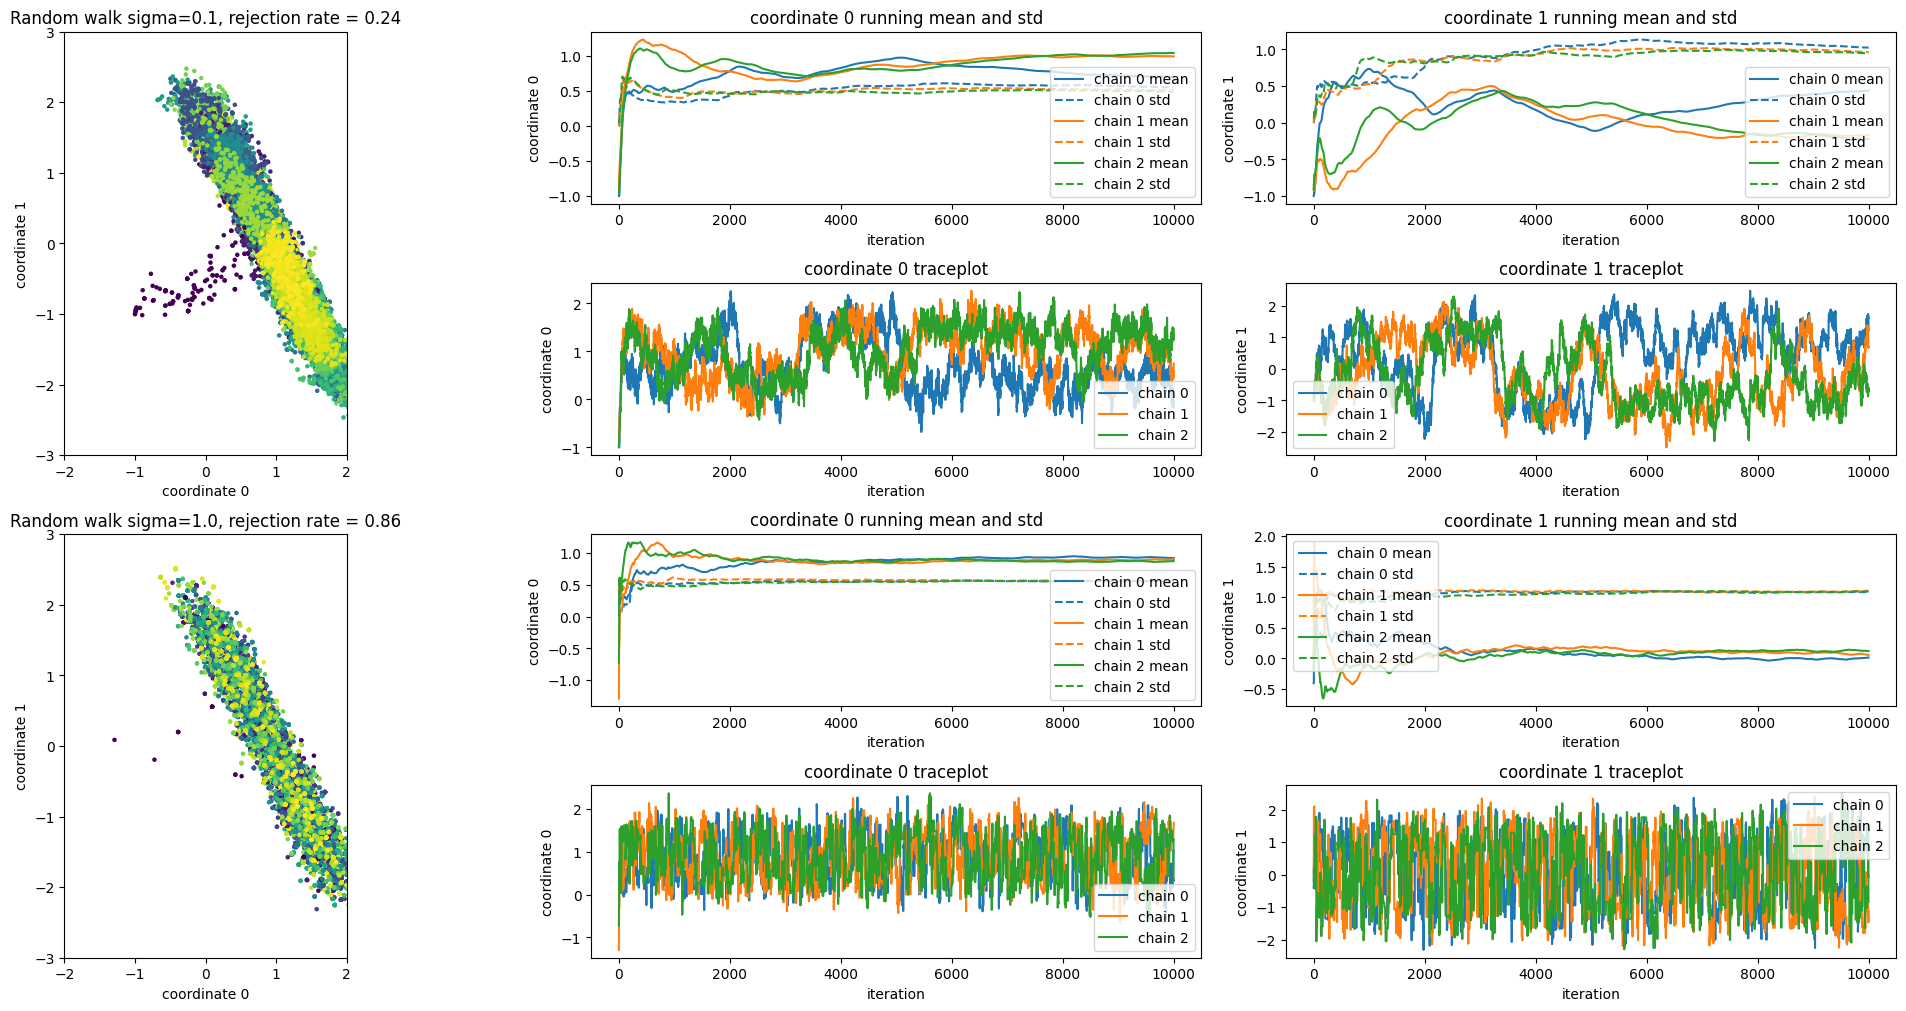

In [30]:
# Watch at plots of statistics and find the right amount of samples for MCMC to converge
# Try out different proposals

convergence_detection_experiment(
    langevin,
    proposals=[
        RandomWalk(0.1), 
        RandomWalk(1.0),
    ],
    options = dict(
        initial_point=torch.tensor([-1., -1.]),
        n_samples=10000,
        n_parallel=3
    )
);